# Models using all variables

## Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold
from yellowbrick.regressor import prediction_error
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import SGD, Adam
from keras import regularizers
from keras.initializers import glorot_uniform

C:\Users\Usuario\AppData\Local\Temp\ipykernel_21916\479639420.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
X_train_std = pd.read_csv("./preprocessed_datasets/X_train_std_perf.csv")
X_test_std = pd.read_csv("./preprocessed_datasets/X_test_std_perf.csv")
y_train = pd.read_csv("./preprocessed_datasets/y_train_perf.csv")
y_test = pd.read_csv("./preprocessed_datasets/y_test_perf.csv")

We standarize the Y values, and transform them to an array

In [3]:
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

## Linear regression models

We drop some identificative columns, so that the model doesn't learn to identify the people and overfits

In [4]:
X_train_std = X_train_std.drop(["index", "ID_Zenodo"], axis=1)
X_test_std = X_test_std.drop(["index", "ID_Zenodo"], axis=1)

### Linear Regression

Initial Linear Regression, with a cross-validation to get the R2 values

In [5]:
lr = LinearRegression(fit_intercept=True).fit(X_train_std ,y_train)
lr_r2_train = r2_score(y_train, lr.predict(X_train_std))
lr_r2_val = cross_val_score(lr, X_train_std, y_train, cv=10, scoring='r2').mean()
lr_r2_test = r2_score(y_test, lr.predict(X_test_std))

lr_mse_train = mean_squared_error(y_train, lr.predict(X_train_std))
lr_mse_test = mean_squared_error(y_test, lr.predict(X_test_std))

In [6]:
print(f"R2 train: {lr_r2_train}")
print(f"R2 val: {lr_r2_val}")
print(f"R2 test: {lr_r2_test}")
print(f"MSE train: {lr_mse_train}")
print(f"MSE test: {lr_mse_test}")

R2 train: 0.31820168453161457
R2 val: 0.2869974818638613
R2 test: 0.28477128558755127
MSE train: 0.6817983154683852
MSE test: 0.7822348966285892


We visualize the predictions

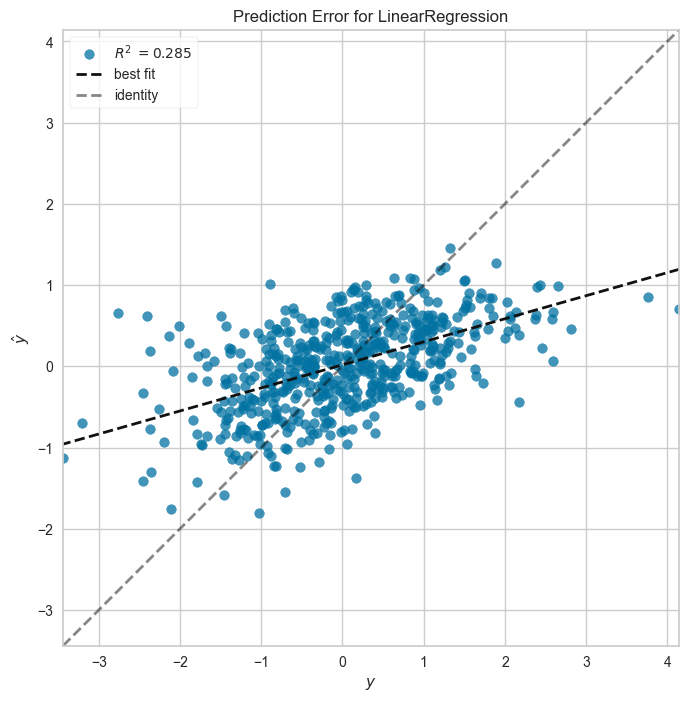

In [7]:
plt.figure(figsize=(8,8))
visualizer = prediction_error(lr, X_test_std, y_test, is_fitted=True)

### Ridge Regression

We implement regularization (Ridge). We use the sklearn RidgeCV to get the best parameter using cross-validation. The parameters
tested are also set by sklearn automatically

In [8]:
ridge_cv = RidgeCV( scoring="r2", cv=10).fit(X_train_std, y_train)
ridge_r2_test= ridge_cv.score(X_test_std, y_test)
ridge_r2_val = ridge_cv.best_score_
ridge_r2_val2 = np.mean(cross_val_score( RidgeCV( scoring="r2", cv=10), X_train_std, y_train, scoring="r2" ))
ridge_r2_train= ridge_cv.score(X_train_std, y_train)

print("Train R2: ", ridge_r2_train)
print("Validation R2: ", ridge_r2_val)
print("Test R2: ", ridge_r2_test)
print(ridge_cv.alpha_)

Train R2:  0.3205805700198089
Validation R2:  0.28697809341619923
Test R2:  0.28375298070340405
10.0


### Lasso Regression

The same as Ridge, but this time Lasso, also with cross-validation

In [9]:
alpha = [1e-3, 1e-2, 1e-1, 1, 100]
lasso_cv = LassoCV(cv=5, random_state=0).fit(X_train_std, y_train)
lasso_r2_test= lasso_cv.score(X_test_std, y_test)
lasso_r2_val = np.mean(cross_val_score( LassoCV(random_state=0, cv=5), X_train_std, y_train, scoring="r2" ))
lasso_r2_train= lasso_cv.score(X_train_std, y_train)

print("Train R2: ", lasso_r2_train)
print("Validation R2: ", lasso_r2_val)
print("Test R2: ", lasso_r2_test)
print(lasso_cv.alpha_)

Train R2:  0.3157212502510993
Validation R2:  0.28743617498571294
Test R2:  0.27943700846653596
0.008135293759221052


### ElasticNet

Elasticnet, combines l1 and l2 regularization. Also uses cross-validation.

In [10]:
alpha = [1e-3, 1e-2, 1e-1, 1, 100]
elasticnet_cv = ElasticNetCV(cv=5, random_state=0).fit(X_train_std, y_train)
elasticnet_r2_test= elasticnet_cv.score(X_test_std, y_test)
elasticnet_r2_val = np.mean(cross_val_score( ElasticNetCV(random_state=0, cv=5), X_train_std, y_train, scoring="r2" ))
elasticnet_r2_train= elasticnet_cv.score(X_train_std, y_train)

print("Train R2: ", elasticnet_r2_train)
print("Validation R2: ", elasticnet_r2_val)
print("Test R2: ", elasticnet_r2_test)
print(elasticnet_cv.alpha_)

Train R2:  0.31585314127375175
Validation R2:  0.28715064199956275
Test R2:  0.27943383679916756
0.015174004375455446


### Linear models results

We visualize the results of the linear models. Note that the test can't be used to determine the best model, only the validation. The test has been added for
comparative purpouses

In [11]:
r2_results = pd.DataFrame({'LR': lr_r2_train, 'Ridge': ridge_r2_train, 'Lasso': lasso_r2_train, 'Elasticnet': elasticnet_r2_train}, index=['Train R2'])


print([lr_r2_val, ridge_r2_val, lasso_r2_val])
lr_r2_val = np.mean(lr_r2_val)
r2_results.loc['CV (Val) R2', :] = [lr_r2_val, ridge_r2_val, lasso_r2_val, elasticnet_r2_val]
r2_results.loc['Test R2', :] = [lr_r2_test, ridge_r2_test, lasso_r2_test, elasticnet_r2_test]


r2_results.loc['lambda','LR']=0
r2_results.loc['lambda','Ridge']=ridge_cv.alpha_
r2_results.loc['lambda','Lasso']=lasso_cv.alpha_
r2_results.loc['lambda','Elasticnet']=elasticnet_cv.alpha_
r2_results


[0.2869974818638613, 0.28697809341619923, 0.28743617498571294]


,LR,Ridge,Lasso,Elasticnet
Train R2,0.318202,0.320581,0.315721,0.315853
CV (Val) R2,0.286997,0.286978,0.287436,0.287151
Test R2,0.284771,0.283753,0.279437,0.279434
lambda,0.000000,10.000000,0.008135,0.015174


We can also visualize the coeficients of the fitted models, to extract some more conclusions

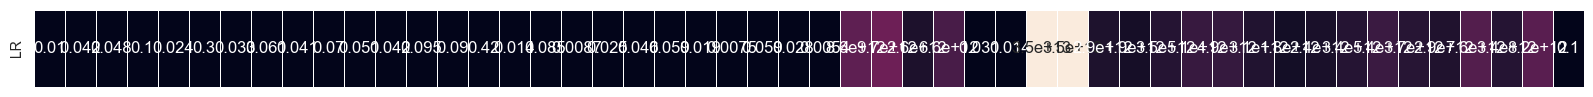

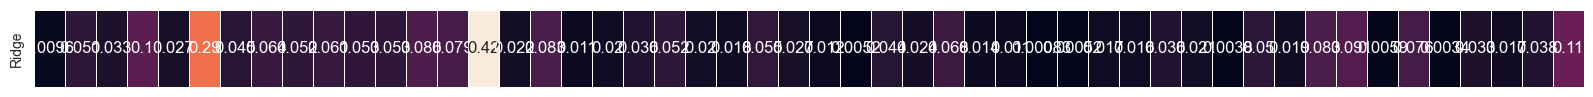

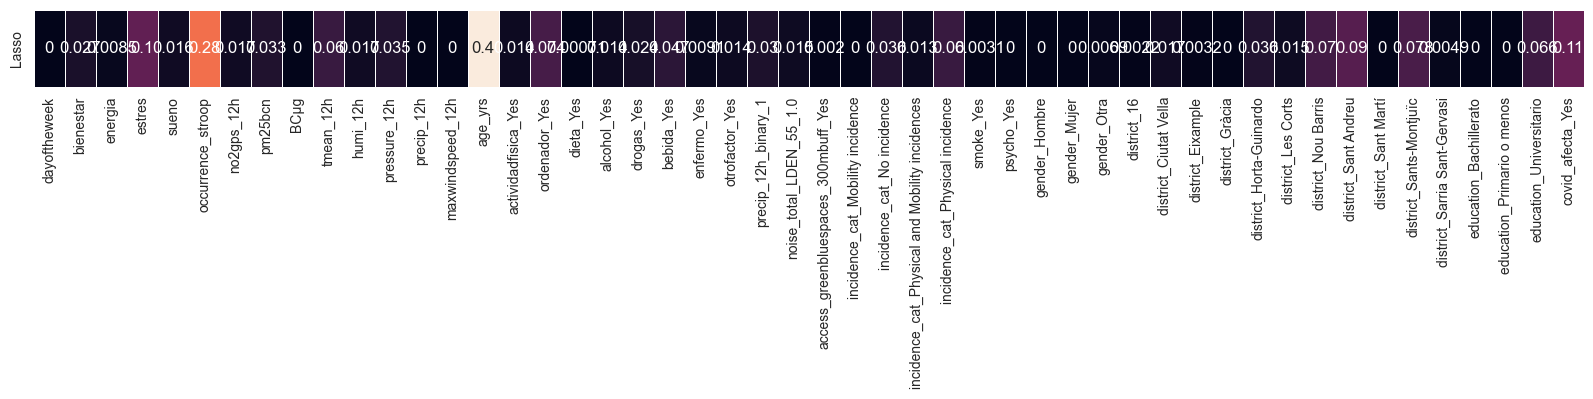

In [12]:
weights = pd.DataFrame({'LR':lr.coef_, 'Ridge':ridge_cv.coef_, 'Lasso':lasso_cv.coef_},index=X_train_std.columns)

fig, ax = plt.subplots(figsize = (20,1))
sns.heatmap(weights.T.loc[['LR'],:].abs(), annot=True, linewidths=.5, ax=ax, cbar=False, xticklabels=False);

plt.figure(figsize = (20,1))
sns.heatmap(weights.T.loc[['Ridge'],:].abs(), annot=True, linewidths=.5, cbar=False, xticklabels=False);

plt.figure(figsize = (20,1))
sns.heatmap(weights.T.loc[['Lasso'],:].abs(), annot=True, linewidths=.5, cbar=False, xticklabels=True);

### Using Statsmodels library

An alternative to sklearn models, we can use a GLM from the StatsModels library, with a gaussian family.

In [13]:
def normality(model, X, y):
  residus = y - model.predict(X)
  f, ax = plt.subplots(figsize=(6,6))
  sns.histplot(data=residus, bins=20, kde=True)
  print(statsmodels.stats.diagnostic.normal_ad(residus))

def linearity(model, X, y):
  f, ax = plt.subplots(figsize=(6,6))

  predictions = model.predict(X)
  ax.scatter(y, predictions)
  ax.plot([0, 1], [0, 1], transform=ax.transAxes, c="red")
  plt.show()

In [14]:
X_train_std = sm.add_constant(X_train_std)  # Add intercept
X_test_std = sm.add_constant(X_test_std) 
glm_model = sm.GLM(y_train, X_train_std, family=sm.families.Gaussian()).fit()

# Print summary
print(glm_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 2251
Model:                            GLM   Df Residuals:                     2204
Model Family:                Gaussian   Df Model:                           46
Link Function:               Identity   Scale:                         0.69417
Method:                          IRLS   Log-Likelihood:                -2759.0
Date:                Tue, 07 May 2024   Deviance:                       1529.3
Time:                        20:39:12   Pearson chi2:                 1.53e+03
No. Iterations:                   100   Pseudo R-squ. (CS):             0.3700
Covariance Type:            nonrobust                                         
                                                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

We can also visualize the results of this model, that has a training R2 of 0.3656 and a test 0.283 (very similar to the other, only a slight difference)

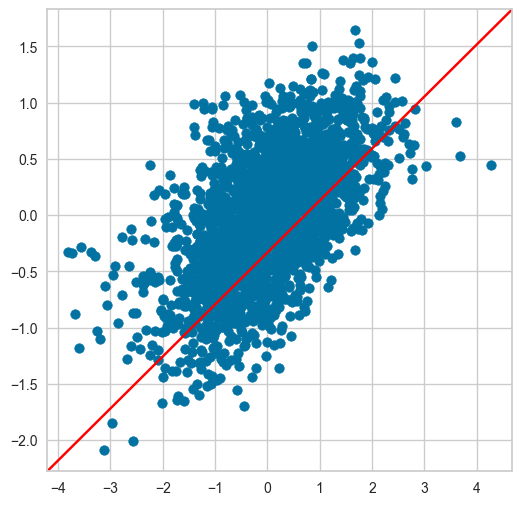

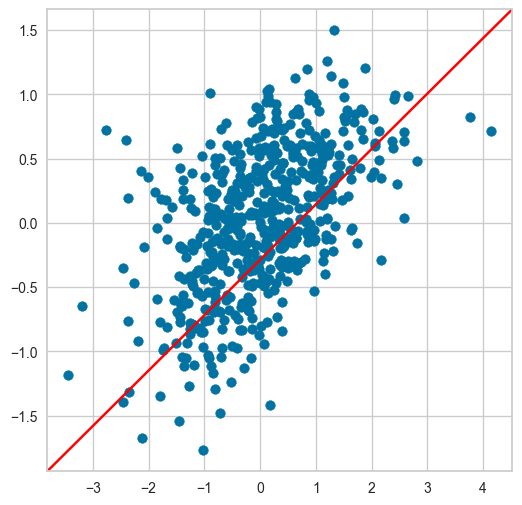

0.28382001754658304

In [15]:
glm_model.predict(X_train_std)
linearity(glm_model, X_train_std, y_train)
linearity(glm_model, X_test_std, y_test)

r2_score(y_test, glm_model.predict(X_test_std))

We assess the normality of the residuals

(1.6495739920351298, 0.0003108457607607882)
(0.7355666378070964, 0.0549581524794816)


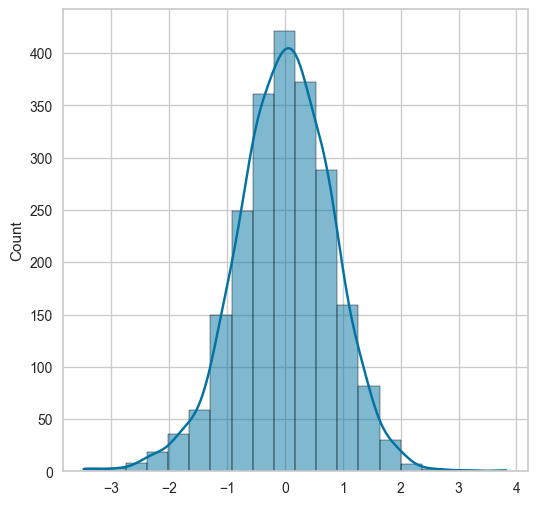

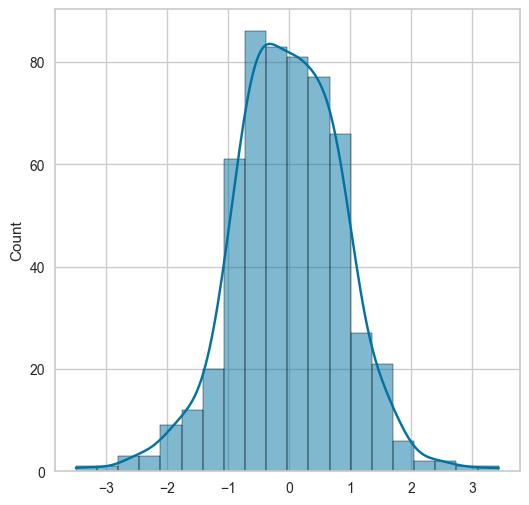

In [16]:
normality(glm_model, X_train_std, y_train)
normality(glm_model, X_test_std, y_test)

# MLP (Multi Layer Perceptron)

Following up, we create the multi layer perceptron. The following function allows us to visualize the evolution during training.

In [17]:
# Plot leaning curves
def plot_curves(history):

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_accuracy = history.history['mean_squared_error']
  val_accuracy = history.history['val_mean_squared_error']
  epochs = range(1, len(train_loss) + 1)

  fig, axes = plt.subplots(1, 2, figsize=(14, 5))

  axes[0].plot(epochs, train_loss, 'g-', label='Training Loss')
  axes[0].plot(epochs, val_loss, 'orange', label='Validation Loss')
  axes[0].set_title('Training and Validation Loss')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Loss')
  axes[0].legend()
  axes[0].grid(True)

  axes[1].plot(epochs, train_accuracy, 'g-', label='Training mean_squared_error')
  axes[1].plot(epochs, val_accuracy, 'orange', label='Validation mean_squared_error')
  axes[1].set_title('Training and Validation mean_squared_error')
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('mean_squared_error')
  axes[1].legend()
  axes[1].grid(True)

  plt.tight_layout()

  plt.show()


## First iteration

In [18]:
# Define the optimizer and learning rate
learning_rate = 0.001

num_epochs = 1000
batch_size = 32

training_r2s = []
training_MSEs = []
validation_r2s = []
validation_MSEs = []

for _ in range(5):
    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)

    model = Sequential([
    Dense(50, activation='relu', input_shape=(X_train_std.shape[1],)),
    Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error', 'r2_score'])
    callback = EarlyStopping(monitor='val_mean_squared_error',patience=15)

    # Train the model

    history = model.fit(X_train_std, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[callback])

    y_train_pred = model.predict(X_train_std)

    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    best_val_r2 = max(history.history['val_r2_score'])  # Final validation loss
    best_val_mse = max(history.history['val_mean_squared_error'])  # Final validation accuracy

    training_r2s.append(train_r2)
    training_MSEs.append(train_mse)
    validation_r2s.append(best_val_r2)
    validation_MSEs.append(best_val_mse)

print("Final Validation MSE:", validation_MSEs)
print("Final Validation R-squared:", validation_r2s)

print("Best Validation MSE:", max(validation_MSEs))
print("Best Validation R-squared:", max(validation_r2s))

print('Training MSE: ', training_MSEs)
print('Training R-squared: ', training_r2s)

print('Best Training MSE: ', max(training_MSEs))
print('Best Training R-squared: ', max(training_r2s))

iterations_r2_train = []
iterations_r2_val = []
iterations_r2_train.append(np.mean(training_r2s))
iterations_r2_val.append(np.mean(validation_r2s))

Epoch 1/1000


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.6157 - mean_squared_error: 1.6157 - r2_score: -0.6358 - val_loss: 0.8864 - val_mean_squared_error: 0.8864 - val_r2_score: 0.0588
Epoch 2/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8815 - mean_squared_error: 0.8815 - r2_score: 0.1319 - val_loss: 0.7049 - val_mean_squared_error: 0.7049 - val_r2_score: 0.2516
Epoch 3/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7563 - mean_squared_error: 0.7563 - r2_score: 0.2772 - val_loss: 0.6407 - val_mean_squared_error: 0.6407 - val_r2_score: 0.3198
Epoch 4/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6305 - mean_squared_error: 0.6305 - r2_score: 0.3391 - val_loss: 0.6186 - val_mean_squared_error: 0.6186 - val_r2_score: 0.3432
Epoch 5/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6107 - mean_squared_error: 0.6107 - r2_score: 0.3868 - val_loss: 0.5855 - val_mean_squared_error: 0.5855 - val_r2_score: 0.3783
Epoch 6/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4820 - mean_squared_error: 1.4820 - r2_score: -0.5245 - val_loss: 0.9020 - val_mean_squared_error: 0.9020 - val_r2_score: 0.0423
Epoch 2/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7727 - mean_squared_error: 0.7727 - r2_score: 0.2441 - val_loss: 0.7188 - val_mean_squared_error: 0.7188 - val_r2_score: 0.2368
Epoch 3/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6954 - mean_squared_error: 0.6954 - r2_score: 0.3056 - val_loss: 0.6715 - val_mean_squared_error: 0.6715 - val_r2_score: 0.2870
Epoch 4/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6056 - mean_squared_error: 0.6056 - r2_score: 0.3727 - val_loss: 0.6588 - val_mean_squared_error: 0.6588 - val_r2_score: 0.3005
Epoch 5/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5781 - mean_squared_error: 0.5781 - r2_score: 0.4093 - val_loss: 0.6365 - val_mean_squared_error: 0.6365 - val_r2_score: 0.3242
Epoch 6/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.6296 - mean_squared_error: 1.6296 - r2_score: -0.6982 - val_loss: 0.7933 - val_mean_squared_error: 0.7933 - val_r2_score: 0.1577
Epoch 2/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8147 - mean_squared_error: 0.8147 - r2_score: 0.1877 - val_loss: 0.6934 - val_mean_squared_error: 0.6934 - val_r2_score: 0.2638
Epoch 3/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7424 - mean_squared_error: 0.7424 - r2_score: 0.2868 - val_loss: 0.6453 - val_mean_squared_error: 0.6453 - val_r2_score: 0.3148
Epoch 4/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6715 - mean_squared_error: 0.6715 - r2_score: 0.3268 - val_loss: 0.6287 - val_mean_squared_error: 0.6287 - val_r2_score: 0.3324
Epoch 5/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6168 - mean_squared_error: 0.6168 - r2_score: 0.3713 - val_loss: 0.5965 - val_mean_squared_error: 0.5965 - val_r2_score: 0.3666
Epoch 6/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4305 - mean_squared_error: 1.4305 - r2_score: -0.4105 - val_loss: 0.7788 - val_mean_squared_error: 0.7788 - val_r2_score: 0.1731
Epoch 2/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7912 - mean_squared_error: 0.7912 - r2_score: 0.2049 - val_loss: 0.6742 - val_mean_squared_error: 0.6742 - val_r2_score: 0.2842
Epoch 3/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6679 - mean_squared_error: 0.6679 - r2_score: 0.3130 - val_loss: 0.6573 - val_mean_squared_error: 0.6573 - val_r2_score: 0.3021
Epoch 4/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6139 - mean_squared_error: 0.6139 - r2_score: 0.3601 - val_loss: 0.6582 - val_mean_squared_error: 0.6582 - val_r2_score: 0.3012
Epoch 5/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6097 - mean_squared_error: 0.6097 - r2_score: 0.4258 - val_loss: 0.6512 - val_mean_squared_error: 0.6512 - val_r2_score: 0.3086
Epoch 6/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4550 - mean_squared_error: 1.4550 - r2_score: -0.4393 - val_loss: 0.8675 - val_mean_squared_error: 0.8675 - val_r2_score: 0.0789
Epoch 2/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7924 - mean_squared_error: 0.7924 - r2_score: 0.1601 - val_loss: 0.7263 - val_mean_squared_error: 0.7263 - val_r2_score: 0.2289
Epoch 3/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7108 - mean_squared_error: 0.7108 - r2_score: 0.3036 - val_loss: 0.6689 - val_mean_squared_error: 0.6689 - val_r2_score: 0.2898
Epoch 4/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6397 - mean_squared_error: 0.6397 - r2_score: 0.3502 - val_loss: 0.6327 - val_mean_squared_error: 0.6327 - val_r2_score: 0.3282
Epoch 5/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5800 - mean_squared_error: 0.5800 - r2_score: 0.4103 - val_loss: 0.6201 - val_mean_squared_error: 0.6201 - val_r2_score: 0.3416
Epoch 6/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

We visualize the evolution

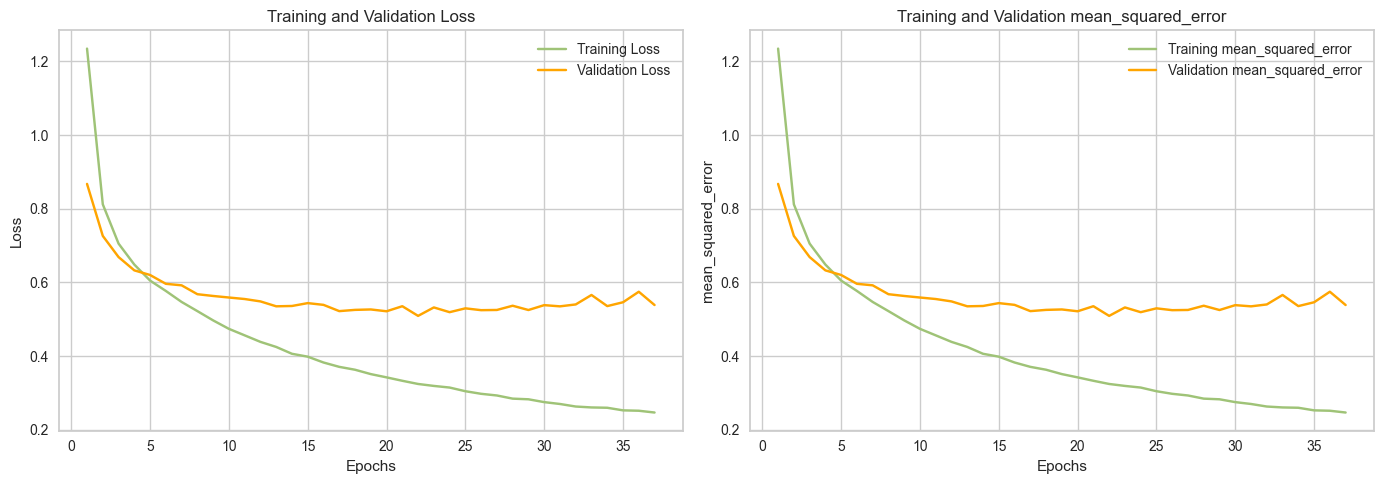

In [19]:
plot_curves(history)

Summary to visualize the number of parameters

In [20]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,955 (31.08 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,304 (20.72 KB)

## Second iteration

Based on the results of the previous iteration, we add some regularization

In [21]:
num_epochs = 1000
batch_size = 32

# Define the learning rate
learning_rate = 0.001


training_r2s = []
training_MSEs = []
validation_r2s = []
validation_MSEs = []
for _ in range(5):
    optimizer = Adam(learning_rate=learning_rate)
    model = Sequential([
    Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train_std.shape[1],)),
    Dropout(0.2),
    Dense(1)
    ])
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error', 'r2_score'])
    callback = EarlyStopping(monitor='val_mean_squared_error', patience=15)

    # Train the model

    history = model.fit(X_train_std, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[callback])

    y_train_pred = model.predict(X_train_std)

    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    best_val_r2 = max(history.history['val_r2_score'])  # Final validation loss is [-1]
    best_val_mse = max(history.history['val_mean_squared_error'])  # Final validation accuracy is [-1]

    training_r2s.append(train_r2)
    training_MSEs.append(train_mse)
    validation_r2s.append(best_val_r2)
    validation_MSEs.append(best_val_mse)

print("Final Validation MSE:", validation_MSEs)
print("Final Validation R-squared:", validation_r2s)

print("Best Validation MSE:", max(validation_MSEs))
print("Best Validation R-squared:", max(validation_r2s))

print('Training MSE: ', training_MSEs)
print('Training R-squared: ', training_r2s)

print('Best Training MSE: ', max(training_MSEs))
print('Best Training R-squared: ', max(training_r2s))

iterations_r2_train.append(np.mean(training_r2s))
iterations_r2_val.append(np.mean(validation_r2s))

Epoch 1/1000


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.1895 - mean_squared_error: 1.6997 - r2_score: -0.7695 - val_loss: 1.3952 - val_mean_squared_error: 0.9534 - val_r2_score: -0.0123
Epoch 2/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4509 - mean_squared_error: 1.0217 - r2_score: -0.0894 - val_loss: 1.1723 - val_mean_squared_error: 0.7775 - val_r2_score: 0.1745
Epoch 3/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2910 - mean_squared_error: 0.9056 - r2_score: 0.0914 - val_loss: 1.0676 - val_mean_squared_error: 0.7081 - val_r2_score: 0.2482
Epoch 4/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1562 - mean_squared_error: 0.8041 - r2_score: 0.2192 - val_loss: 0.9992 - val_mean_squared_error: 0.6678 - val_r2_score: 0.2909
Epoch 5/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0704 - mean_squared_error: 0.7452 - r2_score: 0.3007 - val_loss: 0.9545 - val_mean_squared_error: 0.6474 - val_r2_score: 0.3126
Epoch 6/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.9921 - mean_squared_error: 1.5158 - r2_score: -0.4937 - val_loss: 1.3412 - val_mean_squared_error: 0.9066 - val_r2_score: 0.0374
Epoch 2/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4640 - mean_squared_error: 1.0406 - r2_score: -0.0233 - val_loss: 1.1705 - val_mean_squared_error: 0.7781 - val_r2_score: 0.1739
Epoch 3/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2860 - mean_squared_error: 0.9024 - r2_score: 0.0639 - val_loss: 1.0809 - val_mean_squared_error: 0.7217 - val_r2_score: 0.2337
Epoch 4/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1372 - mean_squared_error: 0.7855 - r2_score: 0.2226 - val_loss: 1.0170 - val_mean_squared_error: 0.6868 - val_r2_score: 0.2707
Epoch 5/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0258 - mean_squared_error: 0.7020 - r2_score: 0.2836 - val_loss: 0.9777 - val_mean_squared_error: 0.6722 - val_r2_score: 0.2863
Epoch 6/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2900 - mean_squared_error: 1.8048 - r2_score: -0.7871 - val_loss: 1.2868 - val_mean_squared_error: 0.8366 - val_r2_score: 0.1117
Epoch 2/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4511 - mean_squared_error: 1.0113 - r2_score: -0.0299 - val_loss: 1.1563 - val_mean_squared_error: 0.7451 - val_r2_score: 0.2089
Epoch 3/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2614 - mean_squared_error: 0.8588 - r2_score: 0.1039 - val_loss: 1.0668 - val_mean_squared_error: 0.6887 - val_r2_score: 0.2688
Epoch 4/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1718 - mean_squared_error: 0.8012 - r2_score: 0.1995 - val_loss: 1.0042 - val_mean_squared_error: 0.6548 - val_r2_score: 0.3047
Epoch 5/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0973 - mean_squared_error: 0.7544 - r2_score: 0.2308 - val_loss: 0.9569 - val_mean_squared_error: 0.6327 - val_r2_score: 0.3282
Epoch 6/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.0034 - mean_squared_error: 1.5106 - r2_score: -0.5585 - val_loss: 1.2997 - val_mean_squared_error: 0.8475 - val_r2_score: 0.1001
Epoch 2/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5346 - mean_squared_error: 1.0938 - r2_score: -0.1068 - val_loss: 1.1419 - val_mean_squared_error: 0.7342 - val_r2_score: 0.2204
Epoch 3/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3011 - mean_squared_error: 0.9034 - r2_score: 0.0941 - val_loss: 1.0474 - val_mean_squared_error: 0.6775 - val_r2_score: 0.2807
Epoch 4/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1997 - mean_squared_error: 0.8383 - r2_score: 0.1315 - val_loss: 0.9931 - val_mean_squared_error: 0.6558 - val_r2_score: 0.3037
Epoch 5/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0627 - mean_squared_error: 0.7323 - r2_score: 0.2415 - val_loss: 0.9507 - val_mean_squared_error: 0.6406 - val_r2_score: 0.3198
Epoch 6/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.4666 - mean_squared_error: 1.9853 - r2_score: -0.9633 - val_loss: 1.4848 - val_mean_squared_error: 1.0431 - val_r2_score: -0.1075
Epoch 2/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6091 - mean_squared_error: 1.1780 - r2_score: -0.1766 - val_loss: 1.2489 - val_mean_squared_error: 0.8469 - val_r2_score: 0.1008
Epoch 3/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3530 - mean_squared_error: 0.9596 - r2_score: 0.0734 - val_loss: 1.1262 - val_mean_squared_error: 0.7575 - val_r2_score: 0.1957
Epoch 4/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2186 - mean_squared_error: 0.8574 - r2_score: 0.1515 - val_loss: 1.0397 - val_mean_squared_error: 0.6998 - val_r2_score: 0.2570
Epoch 5/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1124 - mean_squared_error: 0.7786 - r2_score: 0.2350 - val_loss: 0.9797 - val_mean_squared_error: 0.6640 - val_r2_score: 0.2949
Epoch 6/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 

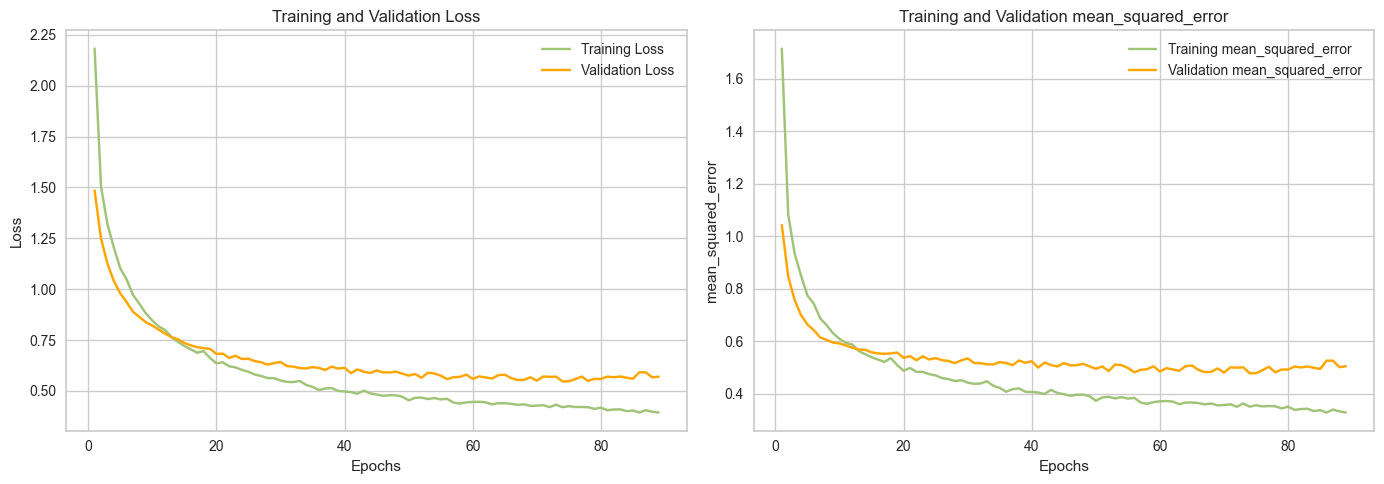

In [22]:
plot_curves(history)

## Third iteration

In this iteration, we try to create a more complex network

In [23]:
# Define the learning rate
learning_rate = 0.001


training_r2s = []
training_MSEs = []
validation_r2s = []
validation_MSEs = []
for _ in range(5):
    optimizer = Adam(learning_rate=learning_rate)
    model = Sequential([
        Dense(200, activation='relu', input_shape=(X_train_std.shape[1],)),
        Dropout(0.5),
        Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.3),
        Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.02)),
        Dropout(0.3),
        Dense(1)
    ])
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error', 'r2_score'])
    callback = EarlyStopping(monitor='val_mean_squared_error', patience=15)

    # Train the model
    num_epochs = 1000
    batch_size = 32
    history = model.fit(X_train_std, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[callback])

    y_train_pred = model.predict(X_train_std)

    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    best_val_r2 = max(history.history['val_r2_score'])
    best_val_mse = max(history.history['val_mean_squared_error'])

    training_r2s.append(train_r2)
    training_MSEs.append(train_mse)
    validation_r2s.append(best_val_r2)
    validation_MSEs.append(best_val_mse)

print("Final Validation MSE:", validation_MSEs)
print("Final Validation R-squared:", validation_r2s)

print("Best Validation MSE:", max(validation_MSEs))
print("Best Validation R-squared:", max(validation_r2s))

print('Training MSE: ', training_MSEs)
print('Training R-squared: ', training_r2s)

print('Best Training MSE: ', max(training_MSEs))
print('Best Training R-squared: ', max(training_r2s))

iterations_r2_train.append(np.mean(training_r2s))
iterations_r2_val.append(np.mean(validation_r2s))

Epoch 1/1000


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.0404 - mean_squared_error: 1.4982 - r2_score: -0.4632 - val_loss: 3.1068 - val_mean_squared_error: 0.8835 - val_r2_score: 0.0619
Epoch 2/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1408 - mean_squared_error: 1.0142 - r2_score: 1.9186e-04 - val_loss: 2.6769 - val_mean_squared_error: 0.8225 - val_r2_score: 0.1267
Epoch 3/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6333 - mean_squared_error: 0.8592 - r2_score: 0.0918 - val_loss: 2.2941 - val_mean_squared_error: 0.7456 - val_r2_score: 0.2084
Epoch 4/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2717 - mean_squared_error: 0.7887 - r2_score: 0.1877 - val_loss: 2.0176 - val_mean_squared_error: 0.7185 - val_r2_score: 0.2371
Epoch 5/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0569 - mean_squared_error: 0.8118 - r2_score: 0.1786 - val_loss: 1.7677 - val_mean_squared_error: 0.6756 - val_r2_score: 0.2827
Epoch 6/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.9314 - mean_squared_error: 1.3919 - r2_score: -0.3813 - val_loss: 3.0784 - val_mean_squared_error: 0.8720 - val_r2_score: 0.0742
Epoch 2/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1070 - mean_squared_error: 0.9996 - r2_score: 0.0116 - val_loss: 2.6625 - val_mean_squared_error: 0.8323 - val_r2_score: 0.1162
Epoch 3/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6383 - mean_squared_error: 0.8887 - r2_score: 0.1119 - val_loss: 2.2874 - val_mean_squared_error: 0.7631 - val_r2_score: 0.1897
Epoch 4/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3075 - mean_squared_error: 0.8487 - r2_score: 0.1522 - val_loss: 1.9913 - val_mean_squared_error: 0.7155 - val_r2_score: 0.2403
Epoch 5/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0030 - mean_squared_error: 0.7799 - r2_score: 0.2488 - val_loss: 1.7211 - val_mean_squared_error: 0.6485 - val_r2_score: 0.3115
Epoch 6/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.8948 - mean_squared_error: 1.3671 - r2_score: -0.3490 - val_loss: 3.0575 - val_mean_squared_error: 0.8846 - val_r2_score: 0.0608
Epoch 2/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0778 - mean_squared_error: 1.0077 - r2_score: -0.0459 - val_loss: 2.6414 - val_mean_squared_error: 0.8573 - val_r2_score: 0.0897
Epoch 3/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6714 - mean_squared_error: 0.9690 - r2_score: 0.0807 - val_loss: 2.2759 - val_mean_squared_error: 0.8028 - val_r2_score: 0.1476
Epoch 4/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2664 - mean_squared_error: 0.8593 - r2_score: 0.1269 - val_loss: 1.9191 - val_mean_squared_error: 0.6966 - val_r2_score: 0.2604
Epoch 5/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9642 - mean_squared_error: 0.7953 - r2_score: 0.2176 - val_loss: 1.7116 - val_mean_squared_error: 0.6940 - val_r2_score: 0.2632
Epoch 6/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.7361 - mean_squared_error: 1.2159 - r2_score: -0.2258 - val_loss: 3.0189 - val_mean_squared_error: 0.8657 - val_r2_score: 0.0808
Epoch 2/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0018 - mean_squared_error: 0.9530 - r2_score: 0.0364 - val_loss: 2.5523 - val_mean_squared_error: 0.7930 - val_r2_score: 0.1581
Epoch 3/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5693 - mean_squared_error: 0.8936 - r2_score: 0.1243 - val_loss: 2.1754 - val_mean_squared_error: 0.7308 - val_r2_score: 0.2241
Epoch 4/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2129 - mean_squared_error: 0.8358 - r2_score: 0.1660 - val_loss: 1.8661 - val_mean_squared_error: 0.6792 - val_r2_score: 0.2788
Epoch 5/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8682 - mean_squared_error: 0.7365 - r2_score: 0.2448 - val_loss: 1.6235 - val_mean_squared_error: 0.6475 - val_r2_score: 0.3125
Epoch 6/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.9186 - mean_squared_error: 1.3775 - r2_score: -0.3016 - val_loss: 3.1102 - val_mean_squared_error: 0.8893 - val_r2_score: 0.0558
Epoch 2/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1686 - mean_squared_error: 1.0460 - r2_score: -0.0345 - val_loss: 2.6717 - val_mean_squared_error: 0.8279 - val_r2_score: 0.1209
Epoch 3/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6548 - mean_squared_error: 0.8930 - r2_score: 0.1063 - val_loss: 2.2659 - val_mean_squared_error: 0.7376 - val_r2_score: 0.2169
Epoch 4/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2794 - mean_squared_error: 0.8194 - r2_score: 0.1538 - val_loss: 1.9644 - val_mean_squared_error: 0.6960 - val_r2_score: 0.2611
Epoch 5/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0001 - mean_squared_error: 0.7885 - r2_score: 0.2150 - val_loss: 1.7077 - val_mean_squared_error: 0.6550 - val_r2_score: 0.3046
Epoch 6/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1

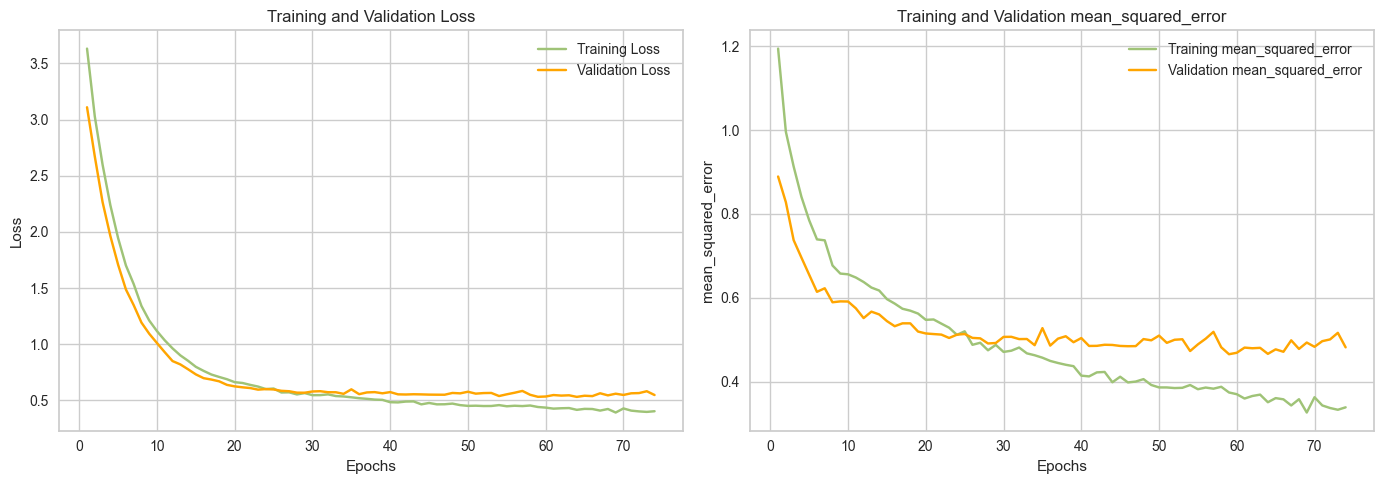

In [24]:
plot_curves(history)

## Fourth iteration

Final iteration, after lots of test.

In [25]:
# Custom activation for the penultimate layer
def clipped_relu(x):
    return tf.keras.backend.relu(x, max_value=1.0)

In [26]:
callback = EarlyStopping(monitor='loss', patience=3)
# Define the learning rate
learning_rate = 0.001

training_r2s = []
training_MSEs = []
validation_r2s = []
validation_MSEs = []
test_MSEs = []
test_r2s = []

for _ in range(5):
    model = Sequential([
    Dense(80, activation='leaky_relu', input_shape=(X_train_std.shape[1],), kernel_initializer=glorot_uniform(), bias_initializer = 'zeros'),
     BatchNormalization(),
    Dropout(0.25),
    Dense(80, activation='leaky_relu', kernel_regularizer=regularizers.l2(0.001), kernel_initializer=glorot_uniform(), bias_initializer = 'zeros'),
     BatchNormalization(),
    Dropout(0.3),
    Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.001), kernel_initializer=glorot_uniform(), bias_initializer = 'zeros'),
     BatchNormalization(),
    Dropout(0.4),
    Dense(100, activation=clipped_relu, kernel_regularizer=regularizers.l2(0.001), kernel_initializer=glorot_uniform(), bias_initializer = 'zeros'),
    Dense(1, kernel_initializer=glorot_uniform())
    ])
    optimizer = Adam(learning_rate=learning_rate)

    # Add warmup and learning rate decay
    lr_scheduler = ReduceLROnPlateau(factor=0.95, patience=10, verbose=0, min_lr=1e-6)
    warmup_epochs = 10
    lr_warmup = lambda epoch: 1e-6 * epoch / warmup_epochs if epoch < warmup_epochs else 1
    # Compile the model
    model.compile(optimizer=optimizer, loss='huber', metrics=['mean_squared_error', 'r2_score'])
    callback = EarlyStopping(monitor='val_mean_squared_error', patience=50, restore_best_weights=True)

    # Train the model
    num_epochs = 1000
    batch_size = 64
    history = model.fit(X_train_std, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[callback, lr_scheduler], initial_epoch=0)

    y_train_pred = model.predict(X_train_std)

    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    best_val_r2 = max(history.history['val_r2_score'])
    best_val_mse = max(history.history['val_mean_squared_error'])

    y_test_pred = model.predict(X_test_std)

    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)


    training_r2s.append(train_r2)
    training_MSEs.append(train_mse)
    validation_r2s.append(best_val_r2)
    validation_MSEs.append(best_val_mse)
    test_MSEs.append(test_mse)
    test_r2s.append(test_r2)

print("Final Validation MSE:", validation_MSEs)
print("Final Validation R-squared:", validation_r2s)

print("Best Validation MSE:", max(validation_MSEs))
print("Best Validation R-squared:", max(validation_r2s))

print('Training MSE: ', training_MSEs)
print('Training R-squared: ', training_r2s)

print('Best Training MSE: ', max(training_MSEs))
print('Best Training R-squared: ', max(training_r2s))

print('Test MSE: ', test_MSEs)
print('Test R-squared: ', test_r2s)

print('Best Test MSE: ', max(test_MSEs))
print('Best Test R-squared: ', max(test_r2s))

iterations_r2_train.append(np.mean(training_r2s))
iterations_r2_val.append(np.mean(validation_r2s))

NameError: name 'glorot_uniform' is not defined

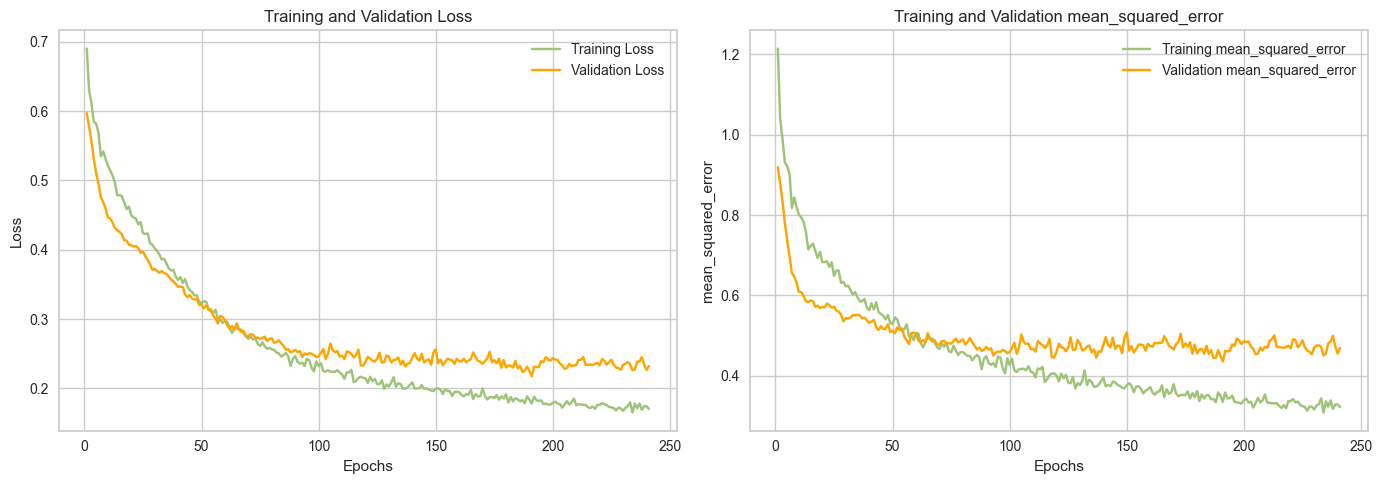

In [ ]:
plot_curves(history)

## Results
We plot the results from all the iterations

In [ ]:
for iter in range(len(iterations_r2_train)):
    print(f"Iteration {iter}")
    print("Train: ", iterations_r2_train[iter])
    print("Validation: ", iterations_r2_val[iter])

Iteration 0
Train:  0.7413482211954013
Validation:  0.4274084806442261
Iteration 1
Train:  0.6952095149698628
Validation:  0.4844201445579529
Iteration 2
Train:  0.7294316121044216
Validation:  0.4999377250671387
Iteration 3
Train:  0.7587219034734602
Validation:  0.5289251804351807


## Using MLPRegressor
As an alternative, we also tried what would a predefined MLP get. The results are similar, only a little bit worse than ours

In [ ]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(hidden_layer_sizes=(800, 800, 800, 400,), random_state=1, max_iter=500).fit(X_train_std, y_train)

regr.score(X_test_std, y_test)

0.4889021750970062